In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import itertools
from pathlib import Path
import sys

# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import xarray as xr

# Util imports
sys.path.append("../../")

# Inverse distance weighting

In [12]:
CITY_NAME = "MetroManila"
STATION_NAMES = ["NAIA", "Port Area", "Science Garden"]
YEARS = [2007, 2008, 2009, 2016, 2017, 2018]
VARS = ["tmin", "tmax", "precip"]

FILL_NA = np.nan

RAW_PATH = Path("../../data/01-raw")
PROCESSED_PATH = Path("../../data/02-processed")
CORRECTED_PATH = PROCESSED_PATH / "bias-correction-radial-optimized"
CORRECTED_PATH.mkdir(parents=True, exist_ok=True)
CORRECTED_IMAGES_PATH = CORRECTED_PATH / "images"
CORRECTED_IMAGES_PATH.mkdir(parents=True, exist_ok=True)

DOMAINS_GEOJSON = RAW_PATH / "domains/downscaling_domains_fixed.geojson"
STATION_LOCATION_CSV = RAW_PATH / "station_data/PAGASA_station_locations.csv"
STATION_DATA_CSV = PROCESSED_PATH / "station_data.csv"

STATION_NC = CORRECTED_PATH / f"station_{CITY_NAME.lower()}.nc"
GRIDDED_NC = (
    PROCESSED_PATH
    / f"input/chirts_chirps_regridded_interpolated_{CITY_NAME.lower()}.nc"
)
GRIDDED_SUBSET_NC = CORRECTED_PATH / f"gridded_{CITY_NAME.lower()}.nc"

CORRECTED_NC = CORRECTED_PATH / f"corrected_gridded_{CITY_NAME.lower()}.nc"

In [3]:
station_locations_df = pd.read_csv(STATION_LOCATION_CSV)
station_locations_df.head()
station_lats = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lat"
].reset_index(drop=True)
station_lons = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lon"
].reset_index(drop=True)
station_lat = station_lats.item() if len(station_lats) == 1 else station_lats.mean()
station_lon = station_lons.item() if len(station_lons) == 1 else station_lons.mean()

In [4]:
stations_df = pd.read_csv(STATION_DATA_CSV)
station_df = (
    stations_df[stations_df["station"].isin(STATION_NAMES)]
    .drop_duplicates()
    .replace(-999, FILL_NA)
    .rename(columns={"rainfall": "precip"})
    .groupby(["station", "date"])
    .mean()
    .sort_values("date")
    .reset_index()
)
station_df["date"] = pd.DatetimeIndex(station_df["date"])
station_df.head()

,station,date,precip,tmax,tmin,tmean,rh,wind_speed,wind_direction
0,NAIA,2007-01-01,0.0,31.4,25.3,28.4,72.0,2.0,90.0
1,Port Area,2007-01-01,0.0,32.5,25.0,28.8,67.0,2.0,90.0
2,Science Garden,2007-01-01,0.4,30.9,23.3,27.1,78.0,1.0,360.0
3,NAIA,2007-01-02,NaN,31.1,25.1,28.1,78.0,2.0,120.0
4,Port Area,2007-01-02,0.0,31.0,26.0,28.5,77.0,2.0,40.0


In [5]:
gridded_all_time_ds = xr.open_dataset(GRIDDED_NC, engine="scipy").sel(band=1)
gridded_ds = gridded_all_time_ds.isel(time=gridded_all_time_ds.time.dt.year.isin(YEARS))

## IDW with Scikit-Learn

In [6]:
gridded_lats = gridded_ds["lat"].to_numpy()
gridded_lons = gridded_ds["lon"].to_numpy()
gridded_df = pd.DataFrame(
    list(itertools.product(gridded_lats, gridded_lons)), columns=["lat", "lon"]
)

time_df = pd.DatetimeIndex(gridded_ds["time"].values)

nlat = len(gridded_lats)
nlon = len(gridded_lons)
ntime = len(time_df)

In [7]:
# X_df = pd.DataFrame(dict(lat=station_lats,lon=station_lons))
# y_df = pd.DataFrame(dict(precip=[0.0,0.3,np.nan])) #station_df.loc[station_df["date"] == time_df[k],var].reset_index(drop=True)

In [8]:
interpolated_ds = gridded_ds[VARS].copy()
for var in VARS:
    print(f"Now doing {var}")

    interpolated_arr = np.zeros((ntime, nlat * nlon))

    for k in range(ntime):
        X_df = pd.DataFrame(dict(lat=station_lats, lon=station_lons))
        y_df = station_df.loc[station_df["date"] == time_df[k], var].reset_index(
            drop=True
        )
        len_not_na = y_df.notna().sum()

        if len_not_na > 0:
            model = KNeighborsRegressor(
                algorithm="kd_tree", n_neighbors=len_not_na, weights="distance"
            )

            model.fit(
                X=X_df[y_df.notna()],
                y=y_df[y_df.notna()],
            )
            interpolated_arr[k] = model.predict(gridded_df)

    interpolated_da = gridded_ds[var].copy()
    interpolated_da.values = interpolated_arr.reshape((ntime, nlat, nlon))
    interpolated_ds[var] = interpolated_da.where(gridded_ds[var].isel(time=0).notnull())
interpolated_ds

Now doing tmin


Now doing tmax
Now doing precip


<xarray.Dataset>
Dimensions:  (time: 2192, lat: 27, lon: 18)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
  * lat      (lat) float64 14.29 14.31 14.33 14.35 ... 14.75 14.77 14.79 14.81
  * lon      (lon) float64 120.9 120.9 120.9 120.9 ... 121.1 121.2 121.2 121.2
    band     int32 1
Data variables:
    tmin     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmax     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    precip   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [9]:
gridded_ds.to_netcdf(CORRECTED_NC, engine="scipy")

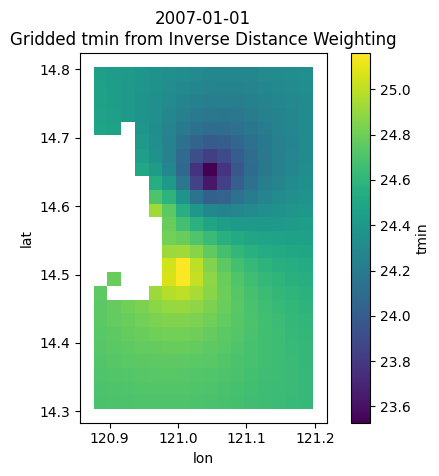

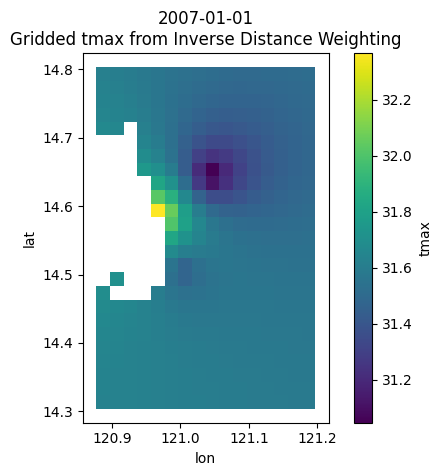

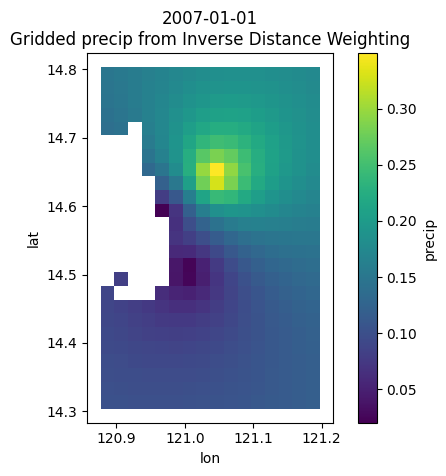

In [13]:
for var in VARS:
    interpolated_ds[var][0].plot()
    plt.gca().set_aspect(1)
    plt.title(
        f"{pd.DatetimeIndex(interpolated_ds['time'])[0].strftime('%Y-%m-%d')}\nGridded {var} from Inverse Distance Weighting"
    )
    plt.savefig(
        CORRECTED_IMAGES_PATH
        / f"{CITY_NAME.split('_')[0].lower()}_interpolated_{var}_idw.png",
        dpi=300,
        transparent=True,
    )
    plt.show()